## Assemble Work Flow Data from CTPP, LODES and Chattanooga Household Survey 2010

In [1]:
import os
import sys
import gzip

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

### CTPP (2012 - 2016) Work Flows

In [2]:
#Folder and file names
ctpp_fldr = os.path.join('..', 'data', 'CTPP')


RPA_tracts_file = os.path.join(ctpp_fldr, 'Tracts_inRPA.csv')
census_geos_file = os.path.join(ctpp_fldr, 'all-geocodes-v2016.csv')

ctpp_download_file = os.path.join(ctpp_fldr,'Job_11651.csv')

In [3]:
tracts = pd.read_csv(RPA_tracts_file, dtype={'GEOID': str})
rta_tracts = list(tracts['GEOID'])
len(rta_tracts)

103

In [35]:
def tract_desc_to_FIPS(census_geo_desc, census_FIPS=None):
    """
    Function that takes a list of census tract in descriptive format
    and returns a list of FIPS in string format.
    Example:
       'Census Tract 112.04, Hamilton County, Tennessee' ==> '47065011204'
    """
    
    assert isinstance(census_FIPS, pd.DataFrame)
    assert isinstance(census_geo_desc, pd.Series)
    
    # Split description to geos
    #'Census Tract 112.04, Hamilton County, Tennessee' => ['Census Tract 112.04','Hamilton County', 'Tennessees']
    geos_df = census_geo_desc.str.split(pat=', ', n=3, expand=True)
    geos_df.rename(columns = dict(zip(geos_df.columns, ['tract','county', 'state'] )), inplace=True)

    # Get StateFIPS from census_FIPS
    geos_df = geos_df.merge(census_FIPS[census_FIPS['SummaryLevel']=='040'][['StateFIPS', 'Name']],
                            how = 'left',
                            left_on = 'state',
                            right_on = 'Name')
    geos_df.drop('Name', inplace=True, axis=1)

    # Get CountyFIPS from Census_FIPS. Note that State and County name both need to match for joining
    geos_df = geos_df.merge(census_FIPS[['CountyFIPS', 'StateFIPS', 'Name']],
                            how = 'left',
                            left_on = ['county', 'StateFIPS'],
                            right_on = ['Name', 'StateFIPS'])
    
    # Convert 'Census Tract 112.04' ==> '011204'
    geos_df['tract_str'] = (
        geos_df['tract']
        .str.split(n=3, expand=True)[2] # only grab the census tract number from "Census Tract 303.03"
        .astype('float')  # from '303.03' to 303.03 
        .mul(100)  # from 303.03 to 30303 (somtime this become 30302.9999)
        .round(1)  # from 30302.9999 to 30303.0
        .astype('int')  # from 30303.0 to 30303 
        .astype('str') # from 30303 to '30303'
        .str.zfill(6) # from '30303' to '030303'
    )
    
    # Add State, County and Tract FIPS together ['47', '065', '011240'] ==> '47065011240'
    geos_df['FIPS'] = geos_df['StateFIPS'] + geos_df['CountyFIPS'] + geos_df['tract_str']
    
    return list(geos_df['FIPS'])

In [94]:
# Pandas optional dependency xrld is needed to read the census geos file.
#  The source of census geos is: "https://www.census.gov/geographies/reference-files/2016/demo/popest/2016-fips.html"
#  This excel file has special characters with accents that may not work with csv format.
#  To avoid using pd.read_excel, the downloaded census geos file was converted to csv.
#  Using 'latin-1' encoding to read accented characters. Will throw errors without encoding.
#
census_geos = pd.read_csv(census_geos_file, dtype='str',  quotechar="'", encoding='latin-1')
new_column_headers = ['SummaryLevel', "StateFIPS", "CountyFIPS", "SubdivFIPS", "PlaceFIPS", "CityFIPS", "Name"]
map_to_new_cols = dict(zip(census_geos.columns, new_column_headers))

census_geos.rename(mapper = map_to_new_cols, inplace = True, axis=1)

# Census geos file downloaded is a long file. Keep only State('040') and County('050') level summaries
# Get rid of SubdicFIPS, PlaceFIPS, and CityFIPS
census_geos = census_geos[
    ((census_geos['SummaryLevel']=='040') | (census_geos['SummaryLevel']=='050'))
    & (census_geos['SubdivFIPS']=='00000')
    & (census_geos['PlaceFIPS']=='00000')
    & (census_geos['CityFIPS']=='00000')
]
census_geos.drop(["SubdivFIPS", "PlaceFIPS", "CityFIPS"], axis=1, inplace=True)
#census_geos

In [37]:
# Read CTPP raw download file and process to remove
#    1. empty last column
#    2. drop "Error" rows
#    3. drop "Output" columns
#    4. drop rows with NaN entries (this is the state level summary)
#    5. reset index
#    6. Convert census description into tract FIPS code for Residence and Work tracts

ctpp_raw_data = pd.read_csv(ctpp_download_file, skiprows=2)
ctpp_raw_data = (
    ctpp_raw_data
    .drop(ctpp_raw_data.columns[-1], axis=1, inplace=False)
    .loc[ctpp_raw_data['Output']=="Estimate"]
    .drop("Output", axis=1, inplace=False)
    .dropna(axis=0, how='any', inplace=False)
    .reset_index()
)

ctpp_raw_data['Res_FIPS'] = tract_desc_to_FIPS(ctpp_raw_data['RESIDENCE'], census_FIPS=census_geos)
ctpp_raw_data['Work_FIPS'] = tract_desc_to_FIPS(ctpp_raw_data['WORKPLACE'], census_FIPS=census_geos)

# QC: make sure the correct number of rows left are 11,964
assert len(ctpp_raw_data)==11964

In [38]:
valid_res_tracts = ctpp_raw_data['Res_FIPS'].isin(rta_tracts)
valid_work_tracts = ctpp_raw_data['Work_FIPS'].isin(rta_tracts)

ctpp_raw_data_only_valid = ctpp_raw_data[valid_res_tracts & valid_work_tracts]
ctpp_raw_data_only_valid['flows'] = (
    ctpp_raw_data_only_valid['Workers 16 and Over']
    .str.replace(',', '')
    .astype('int')
)
#ctpp_raw_data_only_valid

C:\Users\yerra\Anaconda3\envs\chattanooga\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
ctpp_flows = (
    ctpp_raw_data_only_valid
    .groupby(['Res_FIPS', 'Work_FIPS'])
    .agg({'flows': np.sum})
    .reset_index()
    .pivot(index='Res_FIPS', columns='Work_FIPS', values='flows')
    .fillna(value=0)
)
ctpp_flows

Work_FIPS,13047030100,13047030201,13047030202,13047030301,13047030303,13047030304,13047030401,13047030402,13047030500,13047030600,...,47065011700,47065011800,47065011900,47065012000,47065012100,47065012200,47065012300,47065012400,47065980100,47065980200
Res_FIPS,,,,,,,,,,,,,,,,,,,,,
13047030100,165.0,135.0,25.0,40.0,0.0,35.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,130.0,15.0,15.0,0.0,0.0,0.0
13047030201,25.0,295.0,15.0,20.0,15.0,50.0,40.0,0.0,25.0,25.0,...,10.0,15.0,0.0,0.0,25.0,0.0,0.0,0.0,10.0,0.0
13047030202,100.0,210.0,280.0,20.0,0.0,40.0,155.0,25.0,0.0,45.0,...,15.0,0.0,0.0,0.0,25.0,0.0,25.0,25.0,0.0,0.0
13047030301,40.0,170.0,10.0,190.0,20.0,45.0,70.0,0.0,0.0,0.0,...,0.0,35.0,0.0,0.0,35.0,55.0,120.0,10.0,0.0,25.0
13047030303,45.0,115.0,10.0,20.0,65.0,25.0,70.0,10.0,0.0,65.0,...,0.0,4.0,0.0,0.0,20.0,0.0,45.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47065012000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,135.0,4.0,0.0,10.0,20.0,0.0,0.0
47065012100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,335.0,15.0,70.0,15.0,0.0,0.0
47065012200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,35.0,15.0,20.0,0.0,0.0


In [40]:
print(ctpp_raw_data['Workers 16 and Over'].str.replace(',','').astype('float').sum())

print(sum(valid_res_tracts & valid_work_tracts))
print(len(ctpp_raw_data_only_valid))
print("Total work flows before pivot: {:,.0f}".format(ctpp_raw_data_only_valid['flows'].sum()))
print("Total work flows after pivot: {:,.0f}".format(ctpp_flows.sum().sum()))

585652.0
3832
3832
Total work flows before pivot: 161,456
Total work flows after pivot: 161,456


In [41]:
rows = set(list(ctpp_flows.index))
cols = set(list(ctpp_flows.columns))

print(cols - rows)
print(rows - cols)
print(len(rows & cols))

{'47065980100', '47065980200'}
set()
101


### LODES 2018 Work Flows

In [11]:
# LODES files and folders
lodes_fldr = os.path.join('..', 'data', 'LODES')
lodes_files = ["tn_od_main_JT00_2018.csv.gz", "tn_od_aux_JT00_2018.csv.gz",
               "ga_od_main_JT00_2018.csv.gz", "ga_od_aux_JT00_2018.csv.gz" 
              ] #TN->TN, XX->TN, GA->GA, XX->GA

In [12]:
# Get valid tracts as a list of strings. Tracts are FIPS code in string format
tracts = pd.read_csv(RPA_tracts_file, dtype={'GEOID': str})
rta_tracts = list(tracts['GEOID'])
len(rta_tracts)

# Get column names of LODES downloaded files for later use.
#['w_geocode','h_geocode','S000','SA01','SA02','SA03','SE01','SE02','SE03','SI01','SI02','SI03','createdate']
with gzip.open(os.path.join(lodes_fldr, lodes_files[0]), 'rt') as fin:
    column_names = next(fin).strip().split(",")

column_types = [str] * 2 + ['int64'] * 10 + [str]

In [15]:
# Read the downloaded LODES files for #TN->TN, XX->TN, GA->GA, XX->GA
#  and save only flows that are internal-to-internal


def get_valid_lines(file_path, valid_tracts):
    """
    Read the gzip "file_path" file and return a list of lines if both
    the first and second census block groups are in the "valid_tracts".
    These represents the internal flows for the Chattanooga RTA region.
    
    file_path = a string representing path to downloaded LODES file in gzip format (no need to unzip)
    valid_tracts = a list of census tracts to keep. Defines both valid work and home locations.
    
    Return the valid lines as a list of strings.
    """
    
    get_lines = []
    with gzip.open(file_path, 'rt') as fin:
        for line in fin:
            line_as_list = line.strip().split(",")
        
            #If both O and D census blocks are within the valid census tracts, save the line.
            #Otherwise, move on.
            #
            # The slicing [:-4] is to strip the four digits of block group number
            #
            if (line_as_list[0][:-4] in valid_tracts) and (line_as_list[1][:-4] in valid_tracts):
                get_lines.append(line_as_list)
    
    return get_lines
    

valid_lodes_data = []

for file_name in lodes_files:
    file_path= os.path.join(lodes_fldr, file_name)
    valid_lodes_data.append(get_valid_lines(file_path, rta_tracts))

for entry in valid_lodes_data:
    print(len(entry))

91479
18174
9967
2857


In [16]:
# Convert internal-to-internal workflows into a single dataframe

lodes_dataframe = pd.DataFrame([], columns=column_names)

for lodes_od_groups in valid_lodes_data:
    new_df = pd.DataFrame(np.array(lodes_od_groups),
                          columns = column_names,
                          dtype = np.int64 #dict(zip(column_names, column_types))
                         )
    print(len(new_df))
    lodes_dataframe = lodes_dataframe.append(new_df)
    
lodes_dataframe = lodes_dataframe.astype(dict(zip(column_names, column_types)))
#print(len(lodes_dataframe))
#lodes_dataframe.info()

91479
18174
9967
2857


In [17]:
#dict(zip(column_names, column_types))
#
# Create Census tract geo ids stripped of census block group number "stop=-4"
lodes_dataframe = lodes_dataframe.assign(
                    work_geo_id= lambda x: x['w_geocode'].str.slice(stop=-4),
                    home_geo_id= lambda x: x['h_geocode'].str.slice(stop=-4)
                )

# Aggregate workers 16+ age group under the column 'S000' by home to work flow format at census tract level.
# Save the resulting flow table in a separate dataframe
lodes_ods = (lodes_dataframe
              .groupby(['work_geo_id', 'home_geo_id'])
              .agg({'S000': np.sum})
              .reset_index()
              .pivot(index='home_geo_id', columns='work_geo_id', values='S000')
              .fillna(value=0)
            )
    
lodes_ods

work_geo_id,13047030100,13047030201,13047030202,13047030301,13047030303,13047030304,13047030401,13047030402,13047030500,13047030600,...,47065011700,47065011800,47065011900,47065012000,47065012100,47065012200,47065012300,47065012400,47065980100,47065980200
home_geo_id,,,,,,,,,,,,,,,,,,,,,
13047030100,51.0,148.0,23.0,102.0,4.0,29.0,40.0,23.0,7.0,12.0,...,3.0,8.0,0.0,0.0,15.0,1.0,20.0,8.0,2.0,52.0
13047030201,10.0,174.0,16.0,74.0,1.0,20.0,32.0,18.0,12.0,16.0,...,1.0,12.0,0.0,0.0,13.0,3.0,19.0,16.0,1.0,46.0
13047030202,5.0,147.0,51.0,67.0,6.0,18.0,47.0,35.0,17.0,14.0,...,6.0,12.0,0.0,2.0,13.0,9.0,38.0,16.0,1.0,66.0
13047030301,7.0,166.0,25.0,143.0,7.0,32.0,81.0,21.0,4.0,15.0,...,15.0,13.0,0.0,0.0,22.0,2.0,40.0,22.0,5.0,93.0
13047030303,2.0,70.0,9.0,42.0,23.0,39.0,32.0,8.0,4.0,13.0,...,4.0,2.0,0.0,0.0,4.0,0.0,20.0,13.0,1.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47065012200,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,7.0,0.0,0.0,10.0,20.0,26.0,14.0,0.0,53.0
47065012300,0.0,3.0,0.0,9.0,0.0,0.0,4.0,1.0,0.0,0.0,...,5.0,14.0,3.0,0.0,19.0,18.0,103.0,38.0,7.0,124.0
47065012400,0.0,6.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0,...,0.0,0.0,0.0,5.0,8.0,0.0,27.0,106.0,5.0,35.0


In [18]:
lodes_ods.sum().sum()

148914.0

### Process Chattanooga Household Survey 2010 for Work Flows

In [19]:
#Folder and File names
hhs_folder = os.path.join('..', 'data', "HHS2010")
hhs_files = {
    "HH": "HH_deliv_WithWeights.csv",
    "PER": "PER_deliv_WithWeights.csv",
    "PLACE": "PLACE_deliv_WithWeights.csv"
}

hh_taz_mapping_filename = "hh_to_TAZ_mapping.csv"
work_taz_mapping_filename = "work_to_TAZ_mapping.csv"

In [20]:
# Survey data is in older MS Access format
# MS Access database (32 bit format) are not compatible with Python (64 bit)
# Three survey tables in MS Access database were saved in Excel format and then hadled in python
#
#
# Excel format is used to presere the decimal point precision of geocoded coordinates
#(converson from MS Access to csv truncates decimal points with not much control to the user)

hhs_df = pd.read_csv(os.path.join(hhs_folder, hhs_files["HH"]))
per_df = pd.read_csv(os.path.join(hhs_folder, hhs_files["PER"]))

print("Number of household records: {}".format(len(hhs_df)))
print("Number of person records: {}".format(len(per_df)))

Number of household records: 1502
Number of person records: 3422


In [21]:
print("Check number of valid coordinate records\n")
hhs_df.filter(like="CORD", axis=1).info()
print("All household records have non-null coordinates.\n\n")
per_df.filter(like="CORD", axis=1).info()
print("Not all persons work. The number of non-null work locations are fewer than person records.")

Check number of valid coordinate records

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HXCORD  1502 non-null   float64
 1   HYCORD  1502 non-null   float64
dtypes: float64(2)
memory usage: 23.6 KB
All household records have non-null coordinates.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3422 entries, 0 to 3421
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WXCORD  1537 non-null   float64
 1   WYCORD  1537 non-null   float64
 2   SXCORD  634 non-null    float64
 3   SYCORD  634 non-null    float64
dtypes: float64(4)
memory usage: 107.1 KB
Not all persons work. The number of non-null work locations are fewer than person records.


In [22]:
#As a reference for scripting
print(hhs_df.columns)
print(per_df.columns)

Index(['SAMPN', 'STYPE', 'AREA', 'CTFIP', 'WEBRC', 'WEBRT', 'ASSN', 'DOW',
       'ADVLTR', 'LANG', 'HHTRN', 'HHTR2', 'O_HHTRN2', 'HHTR3', 'HHSIZ',
       'HHVEH', 'HHLNG', 'HLANG2', 'O_HLANG2', 'HISP', 'RACE', 'O_RACE',
       'RESTY', 'O_RESTY', 'OWN', 'O_OWN', 'BUSHM', 'INCOM', 'HHSTU', 'HHWRK',
       'HHLIC', 'HHCHD', 'HTRIPS', 'FUTUR', 'HADDR', 'HCITY', 'HSTATE', 'HZIP',
       'HXCORD', 'HYCORD', 'HHWGT', 'EXPHHWGT', 'INCOME_IMP', 'RACE_IMP',
       'HISP_IMP'],
      dtype='object')
Index(['SAMPN', 'PERNO', 'GENDER', 'AGE', 'AGEB', 'LIC', 'DISAB', 'EMPLY',
       'VOLUN', 'WORKS', 'WKSTAT', 'O_WKSTAT', 'JOBS', 'TELCMT', 'OCCUP',
       'O_OCCUP', 'WNAME', 'WTRAV', 'WMODE', 'O_WMODE', 'WSTRT', 'WEND',
       'STUDE', 'SCHOL', 'O_SCHOL', 'SNAME', 'STRAV', 'SMODE', 'O_SMODE',
       'CMPLG', 'INTRV', 'PROXY', 'PTRIPS', 'NOGO', 'O_NOGO', 'WADDR', 'WXST1',
       'WXST2', 'WCITY', 'WSTAT', 'WZIP', 'WXCORD', 'WYCORD', 'SADDR', 'SXST1',
       'SXST2', 'SCITY', 'SSTAT', 'SZIP', 'SXCOR

In [23]:
#Assert that HADDR unique values are sufficient to capture household address uniquely
print(len(hhs_df['HADDR'].unique()))
print(len(pd.Series(hhs_df['HADDR'] + hhs_df['HCITY'] + hhs_df['HSTATE']).unique()))

#Assert that HADDR unique values are sufficient to capture household address uniquely
print(len(per_df['WADDR'].unique()))
print(len(pd.Series(per_df['WADDR'] + per_df['WSTAT']).unique()))

1502
1502
1185
1186


In [24]:
# Read HH and Work to TAZ mappings
hhs_mappings = pd.read_csv(os.path.join(hhs_folder, hh_taz_mapping_filename))
work_mappings = pd.read_csv(os.path.join(hhs_folder, work_taz_mapping_filename))

print(hhs_mappings.columns)
print(work_mappings.columns)

hhs_mappings.rename(columns = {'sampn': 'SAMPN'}, inplace = True)
work_mappings.rename(columns = {'waddrid': 'WADDR_ID',
                                'wxcord': 'WXCORD',
                                'wycord': 'WYCORD'}, inplace = True)

print(hhs_mappings.columns)
print(work_mappings.columns)

Index(['FID_1', 'id', 'sampn', 'haddr', 'hcity', 'hstate', 'hxcord', 'hycord',
       'TAZID', 'COUNTYID', 'STATEID', 'AREA_TYPE', 'DISTR_ID', 'SDISTR_ID',
       'EXTERNAL'],
      dtype='object')
Index(['FID_1', 'id', 'waddrid', 'wxcord', 'wycord', 'TAZID', 'COUNTYID',
       'STATEID', 'AREA_TYPE', 'DISTR_ID', 'SDISTR_ID', 'EXTERNAL'],
      dtype='object')
Index(['FID_1', 'id', 'SAMPN', 'haddr', 'hcity', 'hstate', 'hxcord', 'hycord',
       'TAZID', 'COUNTYID', 'STATEID', 'AREA_TYPE', 'DISTR_ID', 'SDISTR_ID',
       'EXTERNAL'],
      dtype='object')
Index(['FID_1', 'id', 'WADDR_ID', 'WXCORD', 'WYCORD', 'TAZID', 'COUNTYID',
       'STATEID', 'AREA_TYPE', 'DISTR_ID', 'SDISTR_ID', 'EXTERNAL'],
      dtype='object')


In [25]:
# Join TAZ mappings of HHs and wokr to PER dataframe
# Use sampn for joining HH-TAZs (also save district and sdistricts)
# Use WADDR_ID for joining Work-TAZs (also save district and sdistricts)
per_df['WADDR_ID'] = per_df['WADDR'] + '_' +per_df['WCITY'] + '_' + per_df['WSTAT']
per_df_temp = pd.merge(left = per_df,
                       right = hhs_mappings,
                       how = 'left',
                       on = 'SAMPN',)
print(per_df_temp.columns)

work_mappings.astype({'WADDR_ID': 'str'})
per_df_temp.astype({'WADDR_ID': 'str'})
per_df_wMappings = pd.merge(left = per_df_temp,
                            right = work_mappings,
                            how = 'left',
                            left_on = ['WADDR_ID'],
                            right_on = ['WADDR_ID'],
                            suffixes = ('','_work'))

print(per_df_wMappings.columns)

Index(['SAMPN', 'PERNO', 'GENDER', 'AGE', 'AGEB', 'LIC', 'DISAB', 'EMPLY',
       'VOLUN', 'WORKS', 'WKSTAT', 'O_WKSTAT', 'JOBS', 'TELCMT', 'OCCUP',
       'O_OCCUP', 'WNAME', 'WTRAV', 'WMODE', 'O_WMODE', 'WSTRT', 'WEND',
       'STUDE', 'SCHOL', 'O_SCHOL', 'SNAME', 'STRAV', 'SMODE', 'O_SMODE',
       'CMPLG', 'INTRV', 'PROXY', 'PTRIPS', 'NOGO', 'O_NOGO', 'WADDR', 'WXST1',
       'WXST2', 'WCITY', 'WSTAT', 'WZIP', 'WXCORD', 'WYCORD', 'SADDR', 'SXST1',
       'SXST2', 'SCITY', 'SSTAT', 'SZIP', 'SXCORD', 'SYCORD', 'PWGT',
       'EXPPWGT', 'WADDR_ID', 'FID_1', 'id', 'haddr', 'hcity', 'hstate',
       'hxcord', 'hycord', 'TAZID', 'COUNTYID', 'STATEID', 'AREA_TYPE',
       'DISTR_ID', 'SDISTR_ID', 'EXTERNAL'],
      dtype='object')
Index(['SAMPN', 'PERNO', 'GENDER', 'AGE', 'AGEB', 'LIC', 'DISAB', 'EMPLY',
       'VOLUN', 'WORKS', 'WKSTAT', 'O_WKSTAT', 'JOBS', 'TELCMT', 'OCCUP',
       'O_OCCUP', 'WNAME', 'WTRAV', 'WMODE', 'O_WMODE', 'WSTRT', 'WEND',
       'STUDE', 'SCHOL', 'O_SCHOL', 'SNA

In [26]:
# Create a pivot table of workers with valid HH and Work locations
# Work-flows in TAZ X TAZ format

# Aggregate workers 16+ age group under the column 'S000' by home to work flow format at census tract level.
# Save the resulting flow table in a separate dataframe

Os = "TAZID"
Ds = "TAZID_work"

hhs_workflow_taz = (per_df_wMappings[(per_df_wMappings[Os]>0) & (per_df_wMappings[Ds]>0)]
              .groupby([Os, Ds])
              .agg({'EXPPWGT': np.sum})
              .reset_index()
              .pivot(index=Os, columns=Ds, values='EXPPWGT')
              .fillna(value=0)
            )

print(hhs_workflow_taz.sum().sum())
hhs_workflow_taz

201314.72920106002


TAZID_work,1.0,3.0,4.0,5.0,6.0,7.0,8.0,11.0,15.0,17.0,...,888.0,891.0,897.0,901.0,902.0,903.0,904.0,905.0,907.0,909.0
TAZID,,,,,,,,,,,,,,,,,,,,,
1,88.995421,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,172.226853,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,34.863373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,83.348883,338.224501,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,96.855546,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
895,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Create a pivot table of workers with valid HH and Work locations
# Work-flows in District X District format

Os = "DISTR_ID"
Ds = "DISTR_ID_work"

hhs_workflow_dist = (per_df_wMappings[(per_df_wMappings[Os]>0) & (per_df_wMappings[Ds]>0)]
              .groupby([Os, Ds])
              .agg({'EXPPWGT': np.sum})
              .reset_index()
              .pivot(index=Os, columns=Ds, values='EXPPWGT')
              .fillna(value=0)
            )

print(hhs_workflow_dist.sum().sum())
hhs_workflow_dist

201314.72920106002


DISTR_ID_work,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
DISTR_ID,,,,,,,,,,,,
1,897.016720,1247.971824,0.000000,153.757838,0.000000,0.000000,88.932215,144.718449,0.000000,69.032810,0.000000,0.000000
2,5097.496787,5539.043541,570.501674,1227.731658,90.355385,618.427004,1101.476861,1145.127226,0.000000,226.845872,67.125227,79.400511
3,14734.309695,4836.264501,16504.540810,1428.829792,426.697660,722.837207,1439.754370,1824.314102,1283.255767,118.308732,273.639215,195.091347
4,2432.174470,1974.461538,1148.215750,4348.873799,0.000000,139.834406,4049.677191,1671.724247,893.095835,0.000000,1390.010262,456.517866
5,3236.035051,1124.143848,2841.038377,142.881368,3718.459043,1022.058028,823.116432,69.999013,0.000000,0.000000,217.628709,0.000000
6,1301.040568,2216.553689,448.359130,0.000000,0.000000,2440.148898,1083.371390,211.757502,283.970453,38.545870,0.000000,0.000000
7,1433.480588,270.539113,0.000000,118.519955,0.000000,0.000000,1331.073884,623.847305,0.000000,0.000000,0.000000,0.000000
8,4125.782260,3750.856006,416.343904,1612.035390,0.000000,654.109934,3715.877997,5202.082837,604.245324,0.000000,0.000000,36.405071
9,1887.204952,1676.772076,488.169119,449.470528,272.469063,1278.965227,3671.769689,1817.015936,3795.213641,107.709207,0.000000,126.323654


In [28]:
# Create a pivot table of workers with valid HH and Work locations
# Work-flows in SuperDistrict X SuperDistrict format


Os = "SDISTR_ID"
Ds = "SDISTR_ID_work"

hhs_workflow_sdist = (per_df_wMappings[(per_df_wMappings[Os]>0) & (per_df_wMappings[Ds]>0)]
              .groupby([Os, Ds])
              .agg({'EXPPWGT': np.sum})
              .reset_index()
              .pivot(index=Os, columns=Ds, values='EXPPWGT')
              .fillna(value=0)
            )

print(hhs_workflow_sdist.sum().sum())
#hhs_workflow_sdist

201314.72920106


### Summarize Work Flow Data by Super District

In [29]:
#
geos_fldr = '..\data\geos'
tract_to_sd_def_file = os.path.join(geos_fldr, 'tract_to_sdist_mapping.csv')

tract_to_sd_def = pd.read_csv(tract_to_sd_def_file)

In [30]:
geos = tract_to_sd_def['GEOID'].astype('str').to_list()
print(len(geos))
print(set(rta_tracts) - set(geos))
print(set(geos) - set(rta_tracts))

103
set()
set()


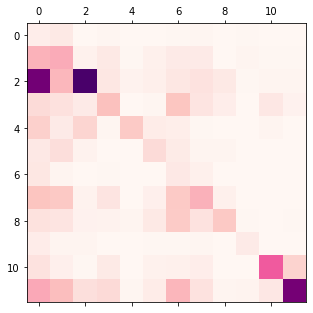

In [93]:
plt.rcParams['figure.figsize'] = 5, 5
plt.matshow(hhs_workflow_dist, cmap=plt.get_cmap('RdPu'))
plt.show()

In [121]:
print(plt.rcParams["figure.figsize"])

[6.0, 4.0]


In [108]:
hhs2010_workflow_per = (hhs_workflow_dist * 10000/(hhs_workflow_dist.sum().sum()))/100
hhs2010_workflow_per

TypeError: int() argument must be a string, a bytes-like object or a number, not 'DataFrame'

In [96]:
def agg_matrix_nxn(matrix, districts):
    """
    Aggregate a matrix to district X district format
    
    matrix: a pandas DataFrame with Os, Ds, and mats format
    districts:  a pandas DatFrame with zones, district format
    
    returns a pandas DataFrame in distric x district format
    """
    
    assert isinstance(matrix, pd.DataFrame)
    assert isinstance(districts, pd.DataFrame)
    assert matrix.shape[1] == 3  # Three columns
    assert districts.shape[1] == 2 # Two columns
    
    matrix.rename(columns = dict(zip(matrix.columns.tolist(), ['Os', 'Ds', 'Vals'])), inplace=True)
    districts.rename(columns = dict(zip(districts.columns.tolist(), ['zone', 'dist'])), inplace=True)
    
    # Forcing the Os & Ds in matrix, and zone and dist in districts to be of string data type
    #
    matrix = matrix.astype({'Os': 'str', 'Ds': 'str'}, copy=False)
    districts = districts.astype({'zone': 'str', 'dist': 'str'}, copy=False)
    
    # Get Origin districts
    matrix = matrix.merge(districts,
                          how = 'left',
                          left_on = 'Os',
                          right_on = 'zone',
                         )
    matrix.rename(columns = {'zone': 'zone_Os', 'dist': 'dist_Os'}, inplace=True)
    
    # Get Destination districts
    matrix = matrix.merge(districts,
                          how = 'left',
                          left_on = 'Ds',
                          right_on = 'zone',
                         )
    matrix.rename(columns = {'zone': 'zone_Ds', 'dist': 'dist_Ds'}, inplace=True)
    
    matrix_dist = (
        matrix
        .groupby(['dist_Os', 'dist_Ds'])
        .agg({'Vals': np.sum})
        .reset_index()
        .pivot(index='dist_Os', columns='dist_Ds', values='Vals')
        .fillna(value=0)
    )
    
    r, c = matrix_dist.shape
    assert r==c
    
    #To sort districts in increasing order: from [1, 10, 11, 12, 2, ....] to [1, 2, 3, ... 12]
    dists = list(map(int, matrix_dist.columns.tolist()))
    dists.sort()
    dists = list(map(str, dists))
    
    matrix_dist = matrix_dist.loc[dists, dists]

    
    return matrix_dist


temp = agg_matrix_nxn(lodes_dataframe[['home_geo_id', 'work_geo_id', 'S000']], tract_to_sd_def)
assert lodes_dataframe['S000'].sum() == temp.sum().sum()
temp

dist_Ds,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
dist_Os,,,,,,,,,,,,,,,
1,3158,384,1033,272,71,505,125,25,36,756,268,197,26,77,88
2,5130,2366,2833,693,166,1224,303,189,160,2705,841,662,190,164,158
3,1661,430,1479,280,87,750,40,34,55,1112,320,341,27,56,79
4,1562,298,872,548,109,561,62,27,27,808,220,204,20,154,97
5,550,96,353,189,158,131,15,7,36,247,69,54,12,49,39
6,3891,970,2922,831,169,2517,100,60,162,3099,1152,1069,87,268,410
7,1859,392,944,261,45,324,523,75,28,735,195,157,90,59,65
8,2802,1496,1989,590,92,853,155,557,99,1884,543,473,377,53,100
9,1796,587,1676,417,66,895,54,80,411,2097,555,1259,56,48,147
